# NLP with Disaster Tweets
We try to predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.
we have a train set and a test set.
We will try to build a machine learning model using NLP to predict the target.
It's a supervised problem and target is a binary categorical variable : 1 or 0

In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Load and EDA the dataset

We are using the train set (csv file downoladed from Kaggle)

In [ ]:
dataset = pd.read_csv("tweeter.csv")

In [ ]:
dataset.head()
#there are 4 variables and one target

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
dataset.shape

(7613, 5)

In [ ]:
dataset.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [ ]:
#checking missing values in the dataset
print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Percentage of missing values: 


id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


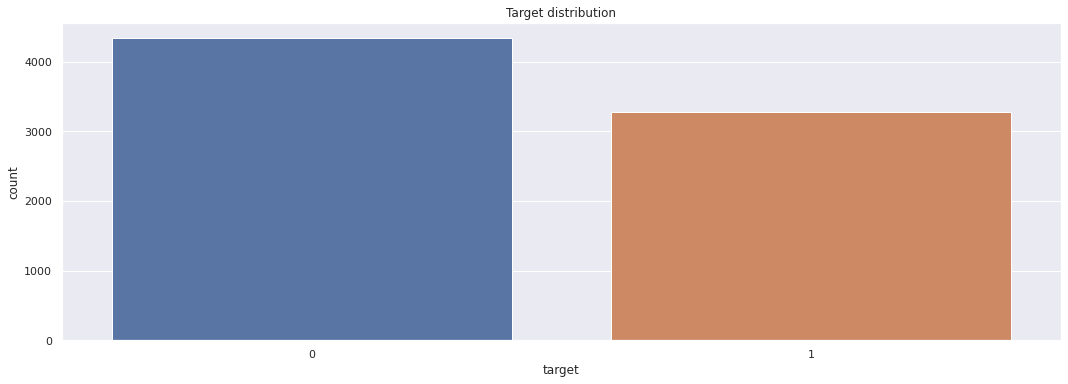

In [ ]:
# Let's explore the data by doing some vizualisations
sns.set_theme(style="darkgrid")
sns.countplot(data.target,data = data).set(title='Target distribution')
plt.show()

In [ ]:
# Visualizing the occurance of keywords column

px.histogram(dataset, x=dataset['keyword'], title='Count of Keyword')
# --> most of keywords semm to have similar count except few ones : evacuated, forest%20truck, terrorim ...

In [ ]:
# Visualizing the occurance of location

px.histogram(dataset, x=dataset['location'], title='Count of Location')
# --> A lot of unique values and a majority of locations are very rarely present in the data set. 

In [ ]:
#let's check the tweets length coloured by target value

dataset['tweet_lengths'] = dataset['text'].apply(lambda x:len(x))
fig = px.histogram(dataset, x="tweet_lengths", color="target")
fig.show()

# --> we can notice that there are more long tweets among tweets with target 0

In [ ]:
# Let's take the columns we're interested in :
# Id is useless to the modelization
# We don't know what to to do wuth key variable, we chose to drop it 
# location have too many missing values, and dont seem to have a direct link with the targe.
data = dataset[['text','target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


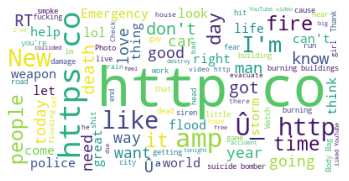

In [ ]:
#word cloud in our dataset
from wordcloud import WordCloud
from PIL import Image
from spacy.lang.en.stop_words import STOP_WORDS

wordcloud = WordCloud(background_color = 'white', stopwords = STOP_WORDS, max_words = 100).generate(' '.join(dataset['text']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# --> Too many stop words need to be cleaned, we will preprocess the text column in order to train an nlp model properly

## Preprocessing text data

In [ ]:
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.8 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
# Remove all non alphanumeric characters except whitespaces
data["text_clean"] = data["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
data["text_clean"] = data["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
data["text_clean"] = data["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
data.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...


###Tokenizing our tweets
Using tf.keras.preprocessing.text.Tokenizer Tokenizer, we encode all the tweets into tokens

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer() 
tokenizer.fit_on_texts(data.text_clean)
data["text_encoded"] = tokenizer.texts_to_sequences(data.text_clean)
data["len_tweet"] = data["text_encoded"].apply(lambda x: len(x))
data = data[data["len_tweet"]!=0] #some tweets might have been entirely erased, we remove those tweets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data.head()

,text,target,text_clean,text_encoded,len_tweet
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[3669, 414, 172, 1381, 1942]",5
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[117, 3, 159, 512, 5555, 5556, 1016]",7
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1382, 447, 1698, 323, 5557, 293, 189, 1698, 3...",11
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[2304, 7, 2305, 70, 189, 279, 35]",7
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[280, 177, 123, 5558, 1699, 168, 70, 2306, 111]",9


###Converting texts and targets into tensors 

In [ ]:
#padding the data
data_pad = tf.keras.preprocessing.sequence.pad_sequences(data.text_encoded, padding="post") #zero padding in order to have all sequences with same length
#tensor slicing the data
full_ds = tf.data.Dataset.from_tensor_slices((data_pad, data.target))

### Train-test split



In [ ]:
# Train Test Split
TAKE_SIZE = int(0.7*data.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [ ]:
# let's take a loook at one batch 
for tweet, target in train_data.take(1):
  print(tweet, target)

tf.Tensor(
[[   28  8311    27 ...     0     0     0]
 [  192  1765  9783 ...     0     0     0]
 [   35    11  1264 ...     0     0     0]
 ...
 [ 5886    63    10 ...     0     0     0]
 [14680   451  5123 ...     0     0     0]
 [  296   276  1135 ...     0     0     0]], shape=(64, 25), dtype=int32) tf.Tensor(
[0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0
 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1], shape=(64,), dtype=int64)


## Modeling
Let's create a model in order to train an embedding!

In [ ]:
tweet.shape

TensorShape([64, 25])

In [ ]:
vocab_size = len(tokenizer.word_index)
embedding_dim=16

model = tf.keras.Sequential([
                  # Input layer Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  # Gobal average pooling, # this will pick the average for every word in the tweet
                  tf.keras.layers.GlobalAveragePooling1D(),
                  # Dense layers
                  tf.keras.layers.Dense(16, activation='relu'),
                  # The prediction layer
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 16)            326256    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 326,545
Trainable params: 326,545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#we oprimize the model with Adam optimizer
optimizer= tf.keras.optimizers.Adam()
#we have a binary classification problem hence the metrics chosen below 
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#we'll then compile the model with 20 epochs
model.fit(
    train_data,
    validation_data=test_data,
    epochs=20)

Epoch 1/20
84/84 [==============================] - 2s 9ms/step - loss: 0.6845 - accuracy: 0.5684 - val_loss: 0.6794 - val_accuracy: 0.5582
Epoch 2/20
84/84 [==============================] - 1s 9ms/step - loss: 0.6586 - accuracy: 0.5800 - val_loss: 0.6584 - val_accuracy: 0.5696
Epoch 3/20
84/84 [==============================] - 1s 14ms/step - loss: 0.5900 - accuracy: 0.6939 - val_loss: 0.6030 - val_accuracy: 0.6935
Epoch 4/20
84/84 [==============================] - 1s 11ms/step - loss: 0.4688 - accuracy: 0.8337 - val_loss: 0.5373 - val_accuracy: 0.7513
Epoch 5/20
84/84 [==============================] - 1s 6ms/step - loss: 0.3509 - accuracy: 0.8829 - val_loss: 0.5026 - val_accuracy: 0.7601
Epoch 6/20
84/84 [==============================] - 1s 9ms/step - loss: 0.2732 - accuracy: 0.9062 - val_loss: 0.4876 - val_accuracy: 0.7701
Epoch 7/20
84/84 [==============================] - 1s 6ms/step - loss: 0.2204 - accuracy: 0.9266 - val_loss: 0.4866 - val_accuracy: 0.7754
Epoch 8/20
84/84 [

The results look quite satisfying for the train set, but the test set loss stops decreasing from epoch 7, the model seems to overfit.

In [ ]:
#let's try to add other layer to the model, like a RNN layers to enhance the model performance

### Model with simple RNN

In [ ]:
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM

model_SRNN = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1,embedding_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  # Gobal average pooling
                  SimpleRNN(units=16, return_sequences=False), # maintains the sequential nature
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  # for the target variable and sigmoid activation
                  Dense(1, activation="sigmoid")
])

In [ ]:
model_SRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 16)            326256    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 327,073
Trainable params: 327,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_SRNN.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Fit the model on 20 epochs
model_SRNN.fit(train_data,
          epochs=20, 
          validation_data=test_data)

Epoch 1/20
84/84 [==============================] - 2s 15ms/step - loss: 0.6037 - accuracy: 0.6806 - val_loss: 0.6424 - val_accuracy: 0.6852
Epoch 2/20
84/84 [==============================] - 1s 12ms/step - loss: 0.2976 - accuracy: 0.8897 - val_loss: 0.7848 - val_accuracy: 0.6537
Epoch 3/20
84/84 [==============================] - 1s 12ms/step - loss: 0.1518 - accuracy: 0.9463 - val_loss: 1.0218 - val_accuracy: 0.6309
Epoch 4/20
84/84 [==============================] - 1s 12ms/step - loss: 0.0857 - accuracy: 0.9728 - val_loss: 1.1988 - val_accuracy: 0.6134
Epoch 5/20
84/84 [==============================] - 1s 12ms/step - loss: 0.0497 - accuracy: 0.9840 - val_loss: 1.3469 - val_accuracy: 0.6270
Epoch 6/20
84/84 [==============================] - 1s 12ms/step - loss: 0.0348 - accuracy: 0.9884 - val_loss: 1.5109 - val_accuracy: 0.6265
Epoch 7/20
84/84 [==============================] - 1s 11ms/step - loss: 0.0267 - accuracy: 0.9902 - val_loss: 1.6661 - val_accuracy: 0.6327
Epoch 8/20
84

In [ ]:
#the model learns faster with a better accuracy on the train but results are poor and overfits even more rapidely on the test set

In [ ]:
#let's try with GRU and 

### Model with GRU layers
Create a model_gru by replacing the SimpleRNN layers by GRU layers

In [ ]:
model_GRU = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1,embedding_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  #GRU layer
                  GRU(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  # for the target variable and sigmoid activation
                  Dense(1, activation="sigmoid")
])

In [ ]:
model_GRU.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Model training 
model_GRU.fit(train_data,
          epochs=20, 
          validation_data=test_data)

Epoch 1/20
84/84 [==============================] - 5s 26ms/step - loss: 0.6829 - accuracy: 0.5707 - val_loss: 0.6874 - val_accuracy: 0.5582
Epoch 2/20
84/84 [==============================] - 2s 21ms/step - loss: 0.5253 - accuracy: 0.7347 - val_loss: 0.5448 - val_accuracy: 0.7447
Epoch 3/20
84/84 [==============================] - 2s 21ms/step - loss: 0.2634 - accuracy: 0.9004 - val_loss: 0.5304 - val_accuracy: 0.7561
Epoch 4/20
84/84 [==============================] - 2s 21ms/step - loss: 0.1376 - accuracy: 0.9527 - val_loss: 0.6931 - val_accuracy: 0.7316
Epoch 5/20
84/84 [==============================] - 2s 21ms/step - loss: 0.0813 - accuracy: 0.9743 - val_loss: 0.7219 - val_accuracy: 0.7163
Epoch 6/20
84/84 [==============================] - 2s 23ms/step - loss: 0.0482 - accuracy: 0.9850 - val_loss: 0.8683 - val_accuracy: 0.7281
Epoch 7/20
84/84 [==============================] - 2s 21ms/step - loss: 0.0388 - accuracy: 0.9897 - val_loss: 0.9170 - val_accuracy: 0.7277
Epoch 8/20
84

In [ ]:
#We are still overfitting but after the 3rd layer. 

In [ ]:
#let's recheck if the dataset is balanced in term of target categories
data.target.value_counts() #our data set is not unproportional in term of target 

0    4342
1    3271
Name: target, dtype: int64

### LSTM layers 

In [ ]:
model_LSTM = tf.keras.Sequential([
                  Embedding(vocab_size+1,embedding_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  #LSTM layer
                  LSTM(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  # last layer
                  Dense(1, activation="sigmoid", name="last")
])

In [ ]:
model_LSTM.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Model training 
model_LSTM.fit(train_data,
          epochs=20, 
          validation_data=test_data)

Epoch 1/20
84/84 [==============================] - 4s 27ms/step - loss: 0.5520 - accuracy: 0.7161 - val_loss: 0.5179 - val_accuracy: 0.7447
Epoch 2/20
84/84 [==============================] - 2s 20ms/step - loss: 0.2577 - accuracy: 0.9071 - val_loss: 0.6266 - val_accuracy: 0.6975
Epoch 3/20
84/84 [==============================] - 2s 21ms/step - loss: 0.1390 - accuracy: 0.9582 - val_loss: 0.6421 - val_accuracy: 0.7198
Epoch 4/20
84/84 [==============================] - 2s 21ms/step - loss: 0.0858 - accuracy: 0.9767 - val_loss: 0.7460 - val_accuracy: 0.7018
Epoch 5/20
84/84 [==============================] - 2s 21ms/step - loss: 0.0595 - accuracy: 0.9844 - val_loss: 1.0740 - val_accuracy: 0.6887
Epoch 6/20
84/84 [==============================] - 2s 21ms/step - loss: 0.0498 - accuracy: 0.9878 - val_loss: 1.0219 - val_accuracy: 0.6799
Epoch 7/20
84/84 [==============================] - 2s 20ms/step - loss: 0.0404 - accuracy: 0.9902 - val_loss: 0.9640 - val_accuracy: 0.6918
Epoch 8/20
84

In [ ]:
#the model still overfits and the loss function on test set is rapidlyincreasing.
#like the previous models (RNN & GRU) it does not generalise well on data never seen
#let's add layers to the LSTM model to see what happens

In [ ]:
model_LSTM2 = tf.keras.Sequential([
                  Embedding(vocab_size+1,embedding_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  #LSTM layer
                  LSTM(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  # last layer
                  Dense(1, activation="sigmoid", name="last")
])

In [ ]:
model_LSTM2.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#Model training 
model_LSTM2.fit(train_data,
          epochs=20, 
          validation_data=test_data)

Epoch 1/20
84/84 [==============================] - 5s 30ms/step - loss: 0.6382 - accuracy: 0.6324 - val_loss: 0.5636 - val_accuracy: 0.7163
Epoch 2/20
84/84 [==============================] - 2s 21ms/step - loss: 0.3590 - accuracy: 0.8694 - val_loss: 0.5235 - val_accuracy: 0.7478
Epoch 3/20
84/84 [==============================] - 2s 20ms/step - loss: 0.1827 - accuracy: 0.9405 - val_loss: 0.5981 - val_accuracy: 0.7338
Epoch 4/20
84/84 [==============================] - 2s 21ms/step - loss: 0.1079 - accuracy: 0.9698 - val_loss: 0.7368 - val_accuracy: 0.7045
Epoch 5/20
84/84 [==============================] - 2s 21ms/step - loss: 0.0651 - accuracy: 0.9824 - val_loss: 1.0536 - val_accuracy: 0.6804
Epoch 6/20
84/84 [==============================] - 2s 24ms/step - loss: 0.0517 - accuracy: 0.9865 - val_loss: 1.1125 - val_accuracy: 0.6830
Epoch 7/20
84/84 [==============================] - 3s 30ms/step - loss: 0.0363 - accuracy: 0.9904 - val_loss: 1.2986 - val_accuracy: 0.6988
Epoch 8/20
84

In [ ]:
# the model performance is still the same
# let's try here the GRU model (best so far) again with bigger embedding dimensions.

In [ ]:
embedding_dim=32
model_GRU2 = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1,embedding_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  #GRU layer
                  GRU(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  # for the target variable and sigmoid activation
                  Dense(1, activation="sigmoid")
])

In [ ]:
model_GRU2.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Model training 
model_GRU2.fit(train_data,
          epochs=20, 
          validation_data=test_data)

Epoch 1/20
84/84 [==============================] - 7s 29ms/step - loss: 0.6836 - accuracy: 0.5755 - val_loss: 0.6879 - val_accuracy: 0.5582
Epoch 2/20
84/84 [==============================] - 2s 23ms/step - loss: 0.5933 - accuracy: 0.6718 - val_loss: 0.5190 - val_accuracy: 0.7614
Epoch 3/20
84/84 [==============================] - 2s 25ms/step - loss: 0.2952 - accuracy: 0.8865 - val_loss: 0.5609 - val_accuracy: 0.7557
Epoch 4/20
84/84 [==============================] - 2s 24ms/step - loss: 0.1343 - accuracy: 0.9546 - val_loss: 0.7926 - val_accuracy: 0.7172
Epoch 5/20
84/84 [==============================] - 2s 24ms/step - loss: 0.0641 - accuracy: 0.9790 - val_loss: 0.7609 - val_accuracy: 0.7312
Epoch 6/20
84/84 [==============================] - 2s 25ms/step - loss: 0.0344 - accuracy: 0.9899 - val_loss: 0.8913 - val_accuracy: 0.7342
Epoch 7/20
84/84 [==============================] - 2s 24ms/step - loss: 0.0233 - accuracy: 0.9919 - val_loss: 1.0479 - val_accuracy: 0.7303
Epoch 8/20
84

In [ ]:
#not better results, let's stick with embedding dim = 16 and and add another layer

In [ ]:
embedding_dim=16
model_GRU3 = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1,embedding_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  #GRU layer
                  GRU(units=32, return_sequences=False), # returns the last output
                  
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  # for the target variable and sigmoid activation
                  Dense(1, activation="sigmoid")
])

In [ ]:
model_GRU.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Model training 
model_GRU.fit(train_data,
          epochs=10, 
          validation_data=test_data)

Epoch 1/10
84/84 [==============================] - 5s 26ms/step - loss: 0.6834 - accuracy: 0.5753 - val_loss: 0.6865 - val_accuracy: 0.5582
Epoch 2/10
84/84 [==============================] - 2s 20ms/step - loss: 0.6783 - accuracy: 0.5761 - val_loss: 0.6336 - val_accuracy: 0.7299
Epoch 3/10
84/84 [==============================] - 2s 21ms/step - loss: 0.3968 - accuracy: 0.8388 - val_loss: 0.4930 - val_accuracy: 0.7675
Epoch 4/10
84/84 [==============================] - 2s 20ms/step - loss: 0.2030 - accuracy: 0.9289 - val_loss: 0.5852 - val_accuracy: 0.7653
Epoch 5/10
84/84 [==============================] - 2s 21ms/step - loss: 0.1121 - accuracy: 0.9638 - val_loss: 0.6230 - val_accuracy: 0.7561
Epoch 6/10
84/84 [==============================] - 2s 20ms/step - loss: 0.0589 - accuracy: 0.9840 - val_loss: 0.7863 - val_accuracy: 0.7281
Epoch 7/10
84/84 [==============================] - 2s 21ms/step - loss: 0.0341 - accuracy: 0.9893 - val_loss: 1.0126 - val_accuracy: 0.7268
Epoch 8/10
84

In [ ]:
#let's add a dropout layer to the model to fight the overfitting

In [ ]:

model_GRU3 = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1,embedding_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  #GRU layer
                  GRU(units=32, return_sequences=False), # returns the last output
                  # Dropout layer 
                  tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
                  # 2 Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(16, activation='relu'),
                  # for the target variable and sigmoid activation
                  Dense(1, activation="sigmoid")
])

In [ ]:
model_GRU3.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Model training 
model_GRU3.fit(train_data,
          epochs=20, 
          validation_data=test_data)

Epoch 1/20
84/84 [==============================] - 6s 29ms/step - loss: 0.6839 - accuracy: 0.5722 - val_loss: 0.6874 - val_accuracy: 0.5582
Epoch 2/20
84/84 [==============================] - 2s 24ms/step - loss: 0.6815 - accuracy: 0.5755 - val_loss: 0.6811 - val_accuracy: 0.5582
Epoch 3/20
84/84 [==============================] - 2s 25ms/step - loss: 0.4496 - accuracy: 0.7983 - val_loss: 0.4911 - val_accuracy: 0.7693
Epoch 4/20
84/84 [==============================] - 2s 24ms/step - loss: 0.2121 - accuracy: 0.9206 - val_loss: 0.5833 - val_accuracy: 0.7478
Epoch 5/20
84/84 [==============================] - 2s 24ms/step - loss: 0.0887 - accuracy: 0.9713 - val_loss: 0.7646 - val_accuracy: 0.7351
Epoch 6/20
84/84 [==============================] - 2s 24ms/step - loss: 0.0422 - accuracy: 0.9856 - val_loss: 0.9892 - val_accuracy: 0.7102
Epoch 7/20
84/84 [==============================] - 2s 24ms/step - loss: 0.0293 - accuracy: 0.9908 - val_loss: 0.9937 - val_accuracy: 0.7202
Epoch 8/20
84

In [ ]:
# Let's make predictions on the first batch of the test set
test_input, test_target = next(iter(test_data))
pred = model_GRU3.predict(test_input)
pred
# we get one porbability for each class

array([[8.95585537e-01],
       [9.97017026e-01],
       [1.53730273e-01],
       [1.41905161e-06],
       [9.98966455e-01],
       [9.98495221e-01],
       [2.71924068e-06],
       [2.33444098e-06],
       [9.58208943e-07],
       [3.73838907e-06],
       [1.61846560e-06],
       [9.99076962e-01],
       [9.87462163e-01],
       [9.99089122e-01],
       [5.48075477e-05],
       [1.18158769e-05],
       [9.98228431e-01],
       [1.00570805e-05],
       [9.98789430e-01],
       [5.00485112e-06],
       [9.99309301e-01],
       [9.99920070e-01],
       [7.35376120e-01],
       [9.31834519e-01],
       [1.39060616e-03],
       [9.99899387e-01],
       [9.99916017e-01],
       [1.42089402e-05],
       [4.49585527e-01],
       [2.41339803e-02],
       [4.03252244e-03],
       [1.00581556e-05],
       [3.57190220e-05],
       [9.82401967e-01],
       [3.89704610e-06],
       [1.82470351e-01],
       [4.31105107e-01],
       [8.00109774e-05],
       [9.99978662e-01],
       [4.08337610e-06],


In [ ]:
# let's convert these predictions into classes
tf.argmax(pred, axis = 1)

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [ ]:
# let's take a look at the target values
test_target

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])>

In [ ]:
# --> for this specific batch the model always predict 0

In [ ]:
test_input

<tf.Tensor: shape=(64, 25), dtype=int32, numpy=
array([[ 4193, 16180,    37, ...,     0,     0,     0],
       [  413,   900,   112, ...,     0,     0,     0],
       [16185, 16186, 16187, ...,     0,     0,     0],
       ...,
       [   89,    18,   476, ...,     0,     0,     0],
       [  111,    54,    87, ...,     0,     0,     0],
       [   89,    18,    77, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
# let's take a look at the test tweets reversed in text format
tokenizer.sequences_to_texts(test_input.numpy()) 

['proud joegoodmanjr watch copalibertadore argentinean pandemonium httpstco8tygo0kizz',
 'pandemonium aba woman deliver baby face photo httptcowrqf6u55hh',
 'pandemoniumiso psp httptcohbpnfoawii',
 'pandemonium use fav cd httptco6whugaem3c',
 'pandemonium aba woman deliver baby face photo httptcoacfi2rhz4n',
 'pandemonium aba woman deliver baby face photo httptcoxrp0rtkffj',
 'world class tgirl ass 02 scene 4 pandemonium httptcoiwcu3dgi1a',
 'hey look review pandemonium amp requiem lauren oliver enjoy httptcocplyrewfz3',
 'element freedom mirage saturday 21 lady free midnight httptco7hanpcr5rk',
 'world class tgirl ass 02 scene 4 pandemonium httptcohzhoa6vzas',
 'khalidkkazi mate ve 2 post tweet pandemonium',
 'pandemonium aba woman deliver baby face photo httptcodi5arr6hq6',
 'gtgt gidiexclusixe shock aba woman deliver ûfacelessûª baby photo pandemonium httptcorgtyzbnkeo bennycapricon',
 'pandemonium aba woman deliver baby face photo httptcoc5u9qsysej',
 'drbaseball41 granttamane8 dre

I think  that there is more to do during the pre processing phase in order to fight the overfiting. Because it looks like many tweets have http links inside them, this part might be confusing the models.
Also may be I should simplify the layers in the models as the model can be too complex. 